# Data Preprocessing

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Install required pkg
! pip install kaggle --quiet

In [ ]:
# config kaggle API
kaggle_api_path = "/content/drive/MyDrive/410_project/kaggle.json"

! mkdir ~/.kaggle
! cp $kaggle_api_path ~/.kaggle/

# change file permissions
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
competition_name = "jigsaw-toxic-comment-classification-challenge"
! kaggle competitions download -c {competition_name}

! mkdir kaggle_data
! unzip {competition_name + ".zip"} -d kaggle_data

# Unmount Google Drive
drive.flush_and_unmount()

In [ ]:
!pip install pandas --quiet

### Temporarily get random 10,000 instances for training, 1,000 for validation, and 1,000 for testing.
For convenience during the exploring stage


In [ ]:
from cgi import test
# Demo few rows of dataset
import pandas as pd

train_df = pd.read_csv('/content/kaggle_data/train.csv.zip')
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle
train_df = train_df.sample(n=10000)

df = pd.read_csv('/content/kaggle_data/test.csv.zip')
df = df.sample(frac=1).reset_index(drop=True) #shuffle
val_df = df.sample(n=1000)

test_df = df.drop(val_df.index).sample(n=1000) #drop the val data and get 1000

# Reset the index for all df
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Feature Engineering

## NLTK's word_tokenize
Usually good for basic NLP tasks

In [ ]:
!pip install nltk --quiet

In [ ]:
# cleaning
import re
def preprocess_and_tokenize(data):
    #convert to lowercase
    data = data.lower()
    #remove non-word characters (excluding spaces)
    data = re.sub(r"[^\w\s]", "", data)
    #tokenize using nltk
    tokens = word_tokenize(data)
    return tokens

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def nltk_tok(data):
  return word_tokenize(data)
train_df['tokenized'] = train_df['comment_text'].apply(preprocess_and_tokenize)
print(train_df[['comment_text', 'tokenized']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                        comment_text  \
0  Will do so.\nAnd someone really needs to write...   
1  Please do not delete the speedy deletion tag -...   
2  "\n, that's a compliment I had never gotten be...   
3  I've found a public domain (primary) source fo...   
4  Official link? \n\nIs http://www.azhar.edu.eg/...   

                                           tokenized  
0  [will, do, so, and, someone, really, needs, to...  
1  [please, do, not, delete, the, speedy, deletio...  
2  [thats, a, compliment, i, had, never, gotten, ...  
3  [ive, found, a, public, domain, primary, sourc...  
4  [official, link, is, httpwwwazharedueg, its, o...  


## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_df = train_df.head(100)

train_df['tokenized_str'] = train_df['tokenized'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df['tokenized_str'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

result_df = pd.concat([train_df[['comment_text', 'tokenized', 'tokenized_str']], tfidf_df], axis=1)

print(result_df[['tokenized_str'] + list(tfidf_df.columns)][:1])


<ipython-input-10-c9252a5dcce2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tokenized_str'] = train_df['tokenized'].apply(lambda tokens: ' '.join(tokens))


                                       tokenized_str   10  100  100riserun  \
0  will do so and someone really needs to write s...  0.0  0.0         0.0   

   108jpg  1133   12  128  142162190217  1477024254  ...  youre  yours  \
0     0.0   0.0  0.0  0.0           0.0         0.0  ...    0.0    0.0   

   yourself  youve  ytterbium  yttrium  zealand  zero0000  zinc  zirconium  
0       0.0    0.0        0.0      0.0      0.0       0.0   0.0        0.0  

[1 rows x 1856 columns]


## Word Embedding

In [ ]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
# Function to get the vector representation for a document
def get_vector(tokens):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

                                       tokenized_str  word2vec_0  word2vec_1  \
0  will do so and someone really needs to write s...   -0.005444    0.005615   

   word2vec_2  word2vec_3  word2vec_4  word2vec_5  word2vec_6  word2vec_7  \
0   -0.001542   -0.000145    0.002744   -0.008284    0.001277    0.012182   

   word2vec_8  ...  word2vec_90  word2vec_91  word2vec_92  word2vec_93  \
0   -0.007525  ...     0.005411     0.002878     0.004517     0.000489   

   word2vec_94  word2vec_95  word2vec_96  word2vec_97  word2vec_98  \
0     0.010688     0.005719     0.004683    -0.005347     0.001659   

   word2vec_99  
0    -0.000586  

[1 rows x 101 columns]


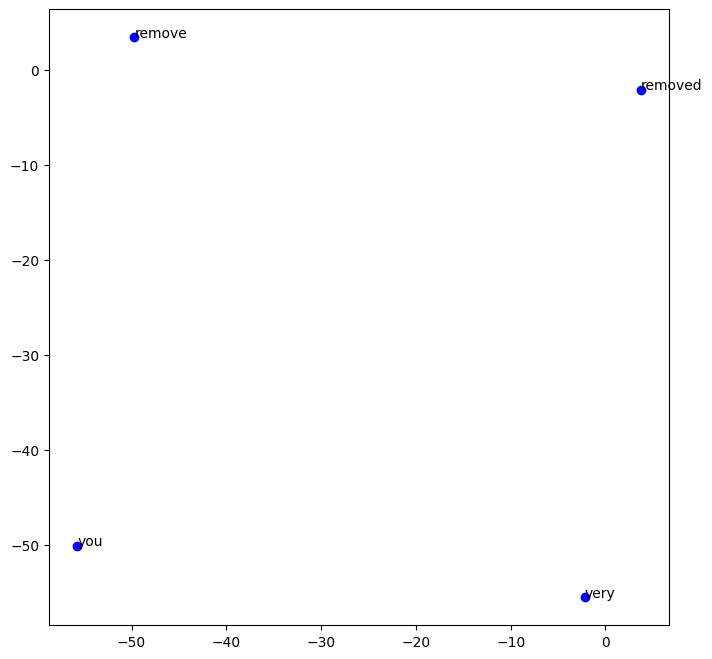

In [ ]:
model = Word2Vec(sentences=train_df['tokenized'], vector_size=100, window=5, min_count=1, workers=4)

#apply the function to each row to get the vector representation for each document
train_df['word2vec'] = train_df['tokenized'].apply(get_vector)

#convert the 'word2vec' column to a DataFrame with separate columns for each dimension
word2vec_df = pd.DataFrame(train_df['word2vec'].to_list(), columns=[f'word2vec_{i}' for i in range(model.vector_size)])

#concatenate the original dataframe and the Word2Vec dataframe
result_df = pd.concat([train_df[['comment_text', 'tokenized', 'tokenized_str']], word2vec_df], axis=1)

print(result_df[['tokenized_str'] + list(word2vec_df.columns)][:1])

#List of words you want to compare for testing
words_for_viz = ['you', 'very', 'removed','remove']

vectors_for_viz = np.array([model.wv[word] for word in words_for_viz])

tsne = TSNE(n_components=2, random_state=42, perplexity=len(words_for_viz)-1)  # Adjust the perplexity value
vectors_2d = tsne.fit_transform(vectors_for_viz)

plt.figure(figsize=(8, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='b', marker='o')
for i, word in enumerate(words_for_viz):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.show()

In [ ]:
print("Vocabulary size:", len(model.wv))
print("Vocabulary:", model.wv.index_to_key)


Vocabulary size: 1872
Vocabulary: ['the', 'to', 'and', 'a', 'of', 'is', 'you', 'i', 'in', 'for', 'that', 'it', 'this', 'on', 'not', 'if', 'be', 'as', 'your', 'have', 'are', 'an', 'page', 'article', 'its', 'no', 'with', 'from', 'but', 'about', 'wikipedia', 'then', 'or', 'talk', 'at', 'what', 'do', 'by', 'so', 'please', 'there', 'some', 'which', 'can', 'one', 'other', 'should', 'was', 'they', 'edit', 'will', 'has', 'we', 'like', 'use', 'my', 'articles', 'may', 'who', 'even', 'me', 'all', 'did', 'deletion', 'just', 'need', 'source', 'edits', 'know', 'been', 'their', 'dont', 'being', 'only', 'out', 'why', 'would', 'these', 'sources', 'information', 'any', 'ive', 'copyright', 'current', 'people', 'them', 'he', 'think', 'used', 'made', 'were', 'see', 'how', 'editing', 'when', 'perhaps', 'notable', 'under', 'help', 'im', 'find', 'ask', 'because', 'drivers', 'also', 'section', 'said', 'infobox', 'deleted', 'again', 'vandalism', 'time', 'now', 'before', 'tag', 'where', 'his', 'hi', 'speedy', 'r

# Model

## Traditional models
such as naive bayes or SVMs

In [ ]:
# Mathworks stated that SVM works very efficiently for binary classification which is our scenario
# We will use svm on our data and then test the model accuracy - if accuracy is low then we can try naive bayes or other classifiers like KNN
# Prototype code below - still needs revision will be done later


## Deep Learning

## Transformer + adversarial training
Charlene Zhang (yuqianz6)

In [ ]:
# BERT

# Reference

In [ ]:
https://www.mathworks.com/campaigns/offers/next/choosing-the-best-machine-learning-classification-model-and-avoiding-overfitting.html
https://www.mathworks.com/help/stats/support-vector-machines-for-binary-classification.html